In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline
plt.style.use('ggplot')

from sqlalchemy import create_engine
from tqdm import tqdm
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.feature_selection import FeatureSelector

%load_ext autoreload
%autoreload 2

In [2]:
# modeling_df_w_pred = pd.read_parquet('../../artifacts/20200920/modeling_df_w_baseline_preds.parquet')
modeling_df = pd.read_parquet('../../artifacts/20201005/modeling_df.parquet')
test_df = pd.read_parquet('../../artifacts/20201005/test_df.parquet')
modeling_df.shape, test_df.shape 

((112599, 201), (88890, 201))

In [6]:
if 'nr_past_tmx' in modeling_df.columns:
    modeling_df.drop('nr_past_tmx', axis=1, inplace=True)
    test_df.drop('nr_past_tmx', axis=1, inplace=True)

In [7]:
v1_features = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'real_ending_balance', # old 'account_ending_balance'
              'days_since_first_deposit' # old 'days_since_first_transaction'
              ]

features = ['transaction_amount', 'real_ending_balance', 'fico_score', 
            'vantage_score', 'all7120', 'all8220', 'bcc2800', 'bcc7120', 
            'bcx3423', 'iln5520', 'iqt9413', 'iqt9415', 'mtf5820', 'stu5031', 
            'credit_card_loan_amount', 'delinquencies_90_days', 'education_loan_amount',
            'mortgage_loan_amount', 'secured_loan_amount', 'total_outstanding_balance', 
            'total_tradelines_open', 'unsecured_loan_amount', 'giact_is_pass', 
            'giact_is_decline', 'giact_is_other', 'giact_nr_pass', 'giact_nr_decline',
            'giact_nr_other', 'fraud_score_1', 'fraud_score_2', 'address_risk_score', 
            'email_risk_score', 'phone_risk_score', 'name_address_correlation', 
            'name_email_correlation', 'name_phone_correlation', 'nr_social_profiles_found', 
            'days_since_first_deposit', 'lag_acc_open_first_transaction', 'first_deposit_amount', 
            'giact_time_since_first_link', 'giact_time_since_last_link', 'transaction_as_pct_of_balance', 
            'time_since_last_transaction', 'nr_past_returns', 'nr_returns_30d', 'nr_past_deposits',
            'nr_deposits_3d', 'nr_deposits_30d', 'nr_past_transactions', 'nr_transactions_3d',
            'nr_transactions_30d', 'pct_returned_deposits', 'pct_returned_deposits_30d',
            'nr_transactions_30d_div_nr_past_transactions', 'mean_account_balance_3d',
            'mean_account_balance_30d', 'std_account_balance_3d', 'std_account_balance_30d', 
            'sum_deposits_3d', 'sum_deposits_10d', 'sum_deposits_30d', 'sum_withdrawals_3d', 
            'sum_withdrawals_10d', 'sum_withdrawals_30d', 'mean_deposits_10d', 
            'mean_deposits', 'mean_deposits_10d_div_mean_deposits', 'mean_withdrawals_10d', 
            'mean_withdrawals', 'mean_withdrawals_10d_div_mean_withdrawals', 'max_deposits_3d', 
            'max_deposits_10d', 'max_deposits_10d_div_mean_deposits',
            'max_deposits_10d_div_mean_account_balance_30d', 'max_withdrawals', 
            'max_withdrawals_3d', 'max_withdrawals_10d', 'max_withdrawals_10d_div_mean_withdrawals',
            'nr_trans_ratio', 'bal_ratio', 'deposits_ratio', 'nr_direct_deposits', 'dollar_val_dd']

def remove_giact(features):
    return list(filter(lambda x: 'giact' not in x, features))

def get_typed_features(df, typed):
    return list(df.columns[df.columns.str.contains(typed)])

# make sure to include plaid and quovo features
quovo_cols = get_typed_features(modeling_df, 'quovo')
plaid_cols = get_typed_features(modeling_df, 'plaid')
tmx_cols = get_typed_features(modeling_df, 'tmx')
features = features + v1_features + quovo_cols + plaid_cols + tmx_cols

features = sorted(list(set(features)))
features = remove_giact(features)

In [9]:
to_remove = []
for f in features:
    try:
        modeling_df[f] = modeling_df[f].astype(float)
    except:
        print(f'feature {f}: is type {modeling_df[f].dtype}')
        to_remove.append(f)

features = [f for f in features if f not in to_remove]

feature plaid_first_link_date: is type datetime64[ns]
feature plaid_last_link_date: is type datetime64[ns]
feature quovo_first_link_date: is type datetime64[ns]
feature quovo_last_link_date: is type datetime64[ns]
feature tmx_created_dt: is type datetime64[ns]
feature tmx_digital_id_trust_score_reason_code: is type object
feature tmx_first_link_dt: is type datetime64[ns]
feature tmx_last_link_dt: is type datetime64[ns]


### Apply our `FeatureSelector` Class
---

In [12]:
fsel = FeatureSelector(modeling_df, label_cols='is_returned', feature_cols=features)

#### WOE

In [13]:
fsel.get_woe(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0) 
fsel.get_iv(method='equal', num_bin_start=10, min_iv=0.02, min_samples_leaf=100, display=0)
fsel.record_iv

producing WOE for all columns with numerical dtype
Attrs removed--missing pct>99%:   ['plaid_largest_checking_or_savings_balance']


/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1086: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1086: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction
/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/pandas/core/algorithms.py:1086: RuntimeWarning: invalid value encountered in double_scalars
  return a + (b - a) * fraction


processed  116  num attributes

WOE fitted
IV produced


,attr,iv
115,vantage_score,1.8953
5,bcc7120,1.5681
110,total_tradelines_open,1.3604
7,credit_card_loan_amount,1.2676
8,days_since_first_deposit,1.1937
...,...,...
56,pct_returned_deposits,0.0000
57,pct_returned_deposits_30d,0.0000
26,max_withdrawals,0.0000
47,nr_past_returns,0.0000


#### Correlation

In [14]:
corr = fsel.get_collinear(-0.6, 0.6)

correlation lowerbound: -0.6
correlation upperbound: 0.6
101 features have correlationbeyond bounds provided


In [15]:
fsel.record_collinear_pairs[:10]

[('all7120', 'bcc7120', 0.660112214763305),
 ('all8220', 'fico_score', 0.6614249034603694),
 ('bal_ratio',
  'max_deposits_10d_div_mean_account_balance_30d',
  -0.999999999996565),
 ('bcc2800', 'bcc7120', 0.6828297637147865),
 ('bcc2800', 'bcx3423', 0.7890034610722224),
 ('bcc7120', 'bcx3423', 0.7063580852753578),
 ('days_since_first_deposit',
  'nr_transactions_30d_div_nr_past_transactions',
  -0.6561824281527142),
 ('days_since_first_deposit',
  'quovo_days_since_first_link',
  0.6889005837861103),
 ('days_since_first_deposit', 'tmx_days_since_first_link', 0.963250072144644),
 ('deposits_ratio', 'nr_trans_ratio', 0.7897540442931811)]

#### Missing Value

In [16]:
fsel.get_missing(0.1).head()

57 features with greater than                 0.1 missing values


,feature,missing_frac
61,plaid_largest_checking_or_savings_balance,1.000000
108,tmx_shipping_address_worst_score,0.836775
107,tmx_shipping_address_score,0.836775
59,plaid_available_bal,0.778266
64,plaid_total_neg_bal,0.778266


#### Single Unique Value

In [17]:
fsel.get_single_unique()

2 features with a single unique value.


,feature,nr_unique
26,max_withdrawals,1
107,tmx_shipping_address_score,1


In [18]:
fsel.record_single_unique

,feature,nr_unique
26,max_withdrawals,1
107,tmx_shipping_address_score,1


#### Boruta

In [19]:
import lightgbm as lgb
count_pos = modeling_df['is_returned'].sum()
count_neg = (~modeling_df['is_returned']).sum()
pos_wgt_scaling_factor = count_neg / count_pos

In [20]:
model = lgb.LGBMClassifier(boosting_type='gbdt', metric='auc', max_depth=4, 
                         n_estimators=250, colsample_bytree=0.6, 
                         learning_rate=0.1, reg_alpha=10, scale_pos_weight=pos_wgt_scaling_factor, 
                         min_data_in_leaf=50, random_state=222)
boruta_params = {
    'features': features,
    'drop_at': -15,
    'max_iter': 50,
    'random_state': 42, 
    'thresh': 0.3,
    'verbose': 1
}
%time fsel.get_boruta_importance(model, **boruta_params)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
CPU times: user 27min 38s, sys: 1.97 s, total: 27min 40s
Wall time: 2min 8s


,feature,score,mean_importance
15,first_deposit_amount,50.0,4.948260
116,vantage_score,50.0,3.943385
13,email_risk_score,45.0,3.008638
114,transaction_as_pct_of_balance,40.0,2.832464
55,nr_transactions_per_day,33.0,2.764047
...,...,...,...
88,tmx_account_address_worst_score,-15.0,0.002566
95,tmx_bb_bot_score,-15.0,0.000855
26,max_withdrawals,-15.0,0.000000
61,plaid_largest_checking_or_savings_balance,-15.0,0.000000


In [21]:
fsel.record_boruta_importance

,feature,score,mean_importance
15,first_deposit_amount,50.0,4.948260
116,vantage_score,50.0,3.943385
13,email_risk_score,45.0,3.008638
114,transaction_as_pct_of_balance,40.0,2.832464
55,nr_transactions_per_day,33.0,2.764047
...,...,...,...
88,tmx_account_address_worst_score,-15.0,0.002566
95,tmx_bb_bot_score,-15.0,0.000855
26,max_withdrawals,-15.0,0.000000
61,plaid_largest_checking_or_savings_balance,-15.0,0.000000


In [22]:
fsel.record_boruta_importance.to_csv('../../artifacts/20201005/boruta_importance_iter0.csv')

<AxesSubplot:>

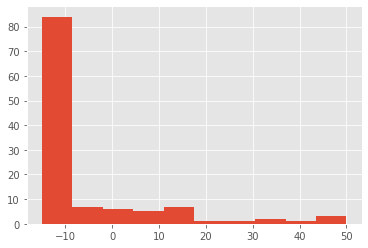

In [23]:
fimp = fsel.record_boruta_importance
fimp.score.hist()

In [24]:
boruta_features_iter0 = fimp[fimp.score>-10].feature.tolist()

#### Remove Highly Correlated Features from Boruta features

In [25]:
corr_ = fsel.get_collinear(-0.6, 0.6, boruta_features_iter0)

correlation lowerbound: -0.6
correlation upperbound: 0.6
8 features have correlationbeyond bounds provided


In [26]:
fsel.record_collinear_pairs

[('transaction_as_pct_of_balance',
  'rolling_trns_as_pct_of_bal',
  0.9743327345547994),
 ('transaction_as_pct_of_balance',
  'transaction_as_pct_of_bal_min',
  0.9338571154141426),
 ('bcc7120', 'all7120', 0.660112214763305),
 ('rolling_trns_as_pct_of_bal',
  'transaction_as_pct_of_bal_min',
  0.9740042281758967),
 ('plaid_max_avail_bal', 'plaid_total_pos_bal', 0.9133281804725447),
 ('fico_score', 'all8220', 0.6614249034603694),
 ('sum_deposits_10d', 'sum_deposits_30d', 0.8402045161558781),
 ('sum_deposits_10d', 'mean_deposits_10d', 0.6733882003174134)]

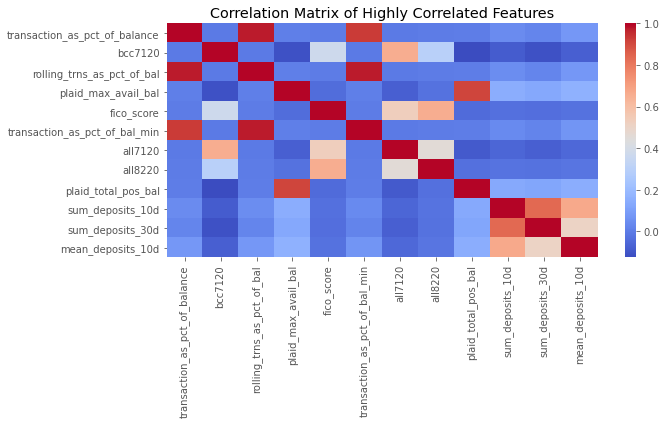

(<Figure size 720x432 with 2 Axes>,
 <AxesSubplot:title={'center':'Correlation Matrix of Highly Correlated Features'}>)

In [27]:
fsel.plot_collinear()

### Save the states of the feature selector 

In [28]:
path = '../../artifacts/20201005/feature_selector_dict.pkl'
fsel.save(path)

state dictionary saved!
